In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import adjusted_rand_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from bertopic import BERTopic
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from transformers import BertTokenizer, BertModel
from collections import defaultdict
from itertools import combinations
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import logging
import sys
import os

# 로깅 설정
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# CUDA 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

# 랜덤 시드 설정
np.random.seed(42)
torch.manual_seed(42)

2024-10-11 01:02:30,301 - INFO - Using device: cpu


In [15]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=50, latent_dim=16):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train_vae(model, optimizer, data_loader, device, epoch):
    model.train()
    train_loss = 0
    for batch in data_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch)
        loss = vae_loss(recon_batch, batch, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_loss = train_loss / len(data_loader.dataset)
    logging.info(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}')
    return avg_loss

def extract_vae_topics(model, data, device, n_clusters=16):
    model.eval()
    with torch.no_grad():
        data_tensor = torch.tensor(data).float().to(device)
        mu, _ = model.encode(data_tensor)
        latent_space = mu.cpu().numpy()
    
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    topics = kmeans.fit_predict(latent_space)
    return topics

In [16]:
def perform_bertopic_modeling(data):
    try:
        bertopic_model = BERTopic(language="english", calculate_probabilities=True)
        result = bertopic_model.fit_transform(data)
        
        # BERTopic의 fit_transform 메서드의 반환 값 구조 확인
        if isinstance(result, tuple) and len(result) == 2:
            topics, _ = result
        else:
            topics = result
        
        num_topics = len(bertopic_model.get_topic_info()) - 1  # -1은 아웃라이어 토픽을 제외하기 위함
        topic_words = []
        for i in range(num_topics):
            words = bertopic_model.get_topic(i)
            topic_words.append([word for word, _ in words[:10]])  # 상위 10개 단어만 추출
        
        return bertopic_model, topic_words, num_topics, topics
    except Exception as e:
        logging.error(f"Error in BERTopic modeling: {str(e)}")
        raise

def calculate_coherence(topics, tokenizer, bert_model):
    coherence_scores = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    bert_model.to(device)
    bert_model.eval()

    for topic_words in topics:
        # 확인: topic_words가 문자열 리스트인지 확인
        if not isinstance(topic_words, list) or not all(isinstance(word, str) for word in topic_words):
            logging.warning(f"Unexpected topic_words format: {topic_words}")
            continue

        inputs = tokenizer(topic_words, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] 토큰의 임베딩 사용

        num_words = len(topic_words)
        if num_words < 2:
            coherence_scores.append(0)
            continue

        pairwise_similarities = []
        for i in range(num_words):
            for j in range(i + 1, num_words):
                cosine_sim = torch.nn.functional.cosine_similarity(embeddings[i], embeddings[j], dim=0)
                pairwise_similarities.append(cosine_sim.item())

        coherence = np.mean(pairwise_similarities)
        coherence_scores.append(coherence)

    final_coherence = np.mean(coherence_scores) if coherence_scores else 0
    return final_coherence

def calculate_npmi(topics, corpus, dictionary, top_n=10):
    topic_words_set = set()
    for topic in topics:
        topic_words_set.update(topic[:top_n])

    word2id = {word: dictionary.token2id[word] for word in topic_words_set if word in dictionary.token2id}
    id2word = {id: word for word, id in word2id.items()}

    total_docs = len(corpus)
    word_doc_freq = defaultdict(int)
    pair_doc_freq = defaultdict(int)

    for doc in corpus:
        doc_word_ids = set([id for id, _ in doc])
        topic_word_ids_in_doc = doc_word_ids.intersection(set(word2id.values()))

        for word_id in topic_word_ids_in_doc:
            word_doc_freq[word_id] += 1

        for word_id1, word_id2 in combinations(topic_word_ids_in_doc, 2):
            pair = tuple(sorted((word_id1, word_id2)))
            pair_doc_freq[pair] += 1

    npmi_scores = []
    for topic in topics:
        topic_word_ids = [word2id[word] for word in topic[:top_n] if word in word2id]
        if len(topic_word_ids) < 2:
            continue
        pair_npmi_scores = []
        for word_id1, word_id2 in combinations(topic_word_ids, 2):
            pair = tuple(sorted((word_id1, word_id2)))
            co_doc_count = pair_doc_freq.get(pair, 0)
            if co_doc_count == 0:
                continue
            p_w1_w2 = co_doc_count / total_docs
            p_w1 = word_doc_freq[word_id1] / total_docs
            p_w2 = word_doc_freq[word_id2] / total_docs

            pmi = np.log(p_w1_w2 / (p_w1 * p_w2) + 1e-12)
            npmi = pmi / (-np.log(p_w1_w2 + 1e-12))
            pair_npmi_scores.append(npmi)
        if pair_npmi_scores:
            npmi_scores.append(np.mean(pair_npmi_scores))

    return np.mean(npmi_scores) if npmi_scores else float('nan')

def calculate_umass(topics, corpus, dictionary, top_n=10):
    topic_words_set = set()
    for topic in topics:
        topic_words_set.update(topic[:top_n])

    word2id = {word: dictionary.token2id[word] for word in topic_words_set if word in dictionary.token2id}

    word_counts = defaultdict(int)
    pair_counts = defaultdict(int)

    for doc in corpus:
        doc_word_ids = set([id for id, _ in doc])
        topic_word_ids_in_doc = doc_word_ids.intersection(set(word2id.values()))

        for word_id in topic_word_ids_in_doc:
            word_counts[word_id] += 1

        for word_id1, word_id2 in combinations(topic_word_ids_in_doc, 2):
            pair = tuple(sorted((word_id1, word_id2)))
            pair_counts[pair] += 1

    umass_scores = []
    for topic in topics:
        topic_word_ids = [word2id[word] for word in topic[:top_n] if word in word2id]
        if len(topic_word_ids) < 2:
            continue
        pair_umass_scores = []
        for i, word_id1 in enumerate(topic_word_ids):
            for word_id2 in topic_word_ids[:i]:
                pair = tuple(sorted((word_id1, word_id2)))
                co_occurrence = pair_counts.get(pair, 0) + 1
                word2_count = word_counts[word_id2] + 1
                umass = np.log(co_occurrence / word2_count)
                pair_umass_scores.append(umass)
        if pair_umass_scores:
            umass_scores.append(np.mean(pair_umass_scores))

    return np.mean(umass_scores) if umass_scores else float('nan')

def process_metrics(model_type, topics, data, metrics_list, tokenizer, bert_model):
    tokenized_data = [doc.split() for doc in data['text']]  # 간단한 토큰화
    dictionary = Dictionary(tokenized_data)
    corpus = [dictionary.doc2bow(text) for text in tokenized_data]

    # VAE 모델의 경우 토픽 형식 수정
    if model_type == 'VAE':
        topics = [[word for word in topic if isinstance(word, str)] for topic in topics]

    coherence = calculate_coherence(topics, tokenizer, bert_model)
    npmi = calculate_npmi(topics, corpus, dictionary)
    umass = calculate_umass(topics, corpus, dictionary)

    metrics_list.append({
        'Model': model_type,
        'Coherence': coherence,
        'NPMI': npmi,
        'U_Mass': umass
    })

    logging.info(f"{model_type} - Coherence: {coherence:.4f}, NPMI: {npmi:.4f}, U_Mass: {umass:.4f}")


def calculate_correlation(metrics_list, ari_list):
    coherence_values = [metric['Coherence'] for metric in metrics_list]
    npmi_values = [metric['NPMI'] for metric in metrics_list]
    umass_values = [metric['U_Mass'] for metric in metrics_list]

    correlation_coherence, _ = pearsonr(coherence_values, ari_list)
    correlation_npmi, _ = pearsonr(npmi_values, ari_list)
    correlation_umass, _ = pearsonr(umass_values, ari_list)

    logging.info(f"Correlation between ARI and Coherence: {correlation_coherence:.4f}")
    logging.info(f"Correlation between ARI and NPMI: {correlation_npmi:.4f}")
    logging.info(f"Correlation between ARI and U_Mass: {correlation_umass:.4f}")

    return correlation_coherence, correlation_npmi, correlation_umass

def plot_metrics(metrics_list, ari_list):
    plt.figure(figsize=(15, 10))
    metrics = ['Coherence', 'NPMI', 'U_Mass']
    colors = ['blue', 'green', 'red']
    
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        for j, model in enumerate(['VAE', 'BERTopic']):
            metric_value = metrics_list[j][metric]
            ari = ari_list[j]
            plt.scatter(metric_value, ari, color=colors[i], label=f'{metric} ({model})')
        plt.title(f'{metric} vs ARI')
        plt.xlabel(metric)
        plt.ylabel('ARI')
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('topic_modeling_metrics.png')
    logging.info("Metrics plot saved as 'topic_modeling_metrics.png'")

2024-10-11 01:02:30,401 - INFO - Loading data...
2024-10-11 01:02:30,667 - INFO - Training VAE model...
2024-10-11 01:02:30,983 - INFO - ====> Epoch: 0 Average loss: 2463.3233
2024-10-11 01:02:31,293 - INFO - ====> Epoch: 1 Average loss: 294.7365
2024-10-11 01:02:31,590 - INFO - ====> Epoch: 2 Average loss: 99.1870
2024-10-11 01:02:31,883 - INFO - ====> Epoch: 3 Average loss: 86.2249
2024-10-11 01:02:32,186 - INFO - ====> Epoch: 4 Average loss: 79.5089
2024-10-11 01:02:32,254 - INFO - ARI for VAE: 0.0606
2024-10-11 01:02:32,255 - INFO - Performing BERTopic modeling...
2024-10-11 01:02:32,260 - INFO - Use pytorch device_name: cpu
2024-10-11 01:02:32,261 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-10-11 01:03:00,290 - INFO - ARI for BERTopic: 0.3633
2024-10-11 01:03:07,171 - INFO - adding document #0 to Dictionary<0 unique tokens: []>
2024-10-11 01:03:07,252 - INFO - built Dictionary<10111 unique tokens: ['atom', 'behavior', 'chemistry', 'cla

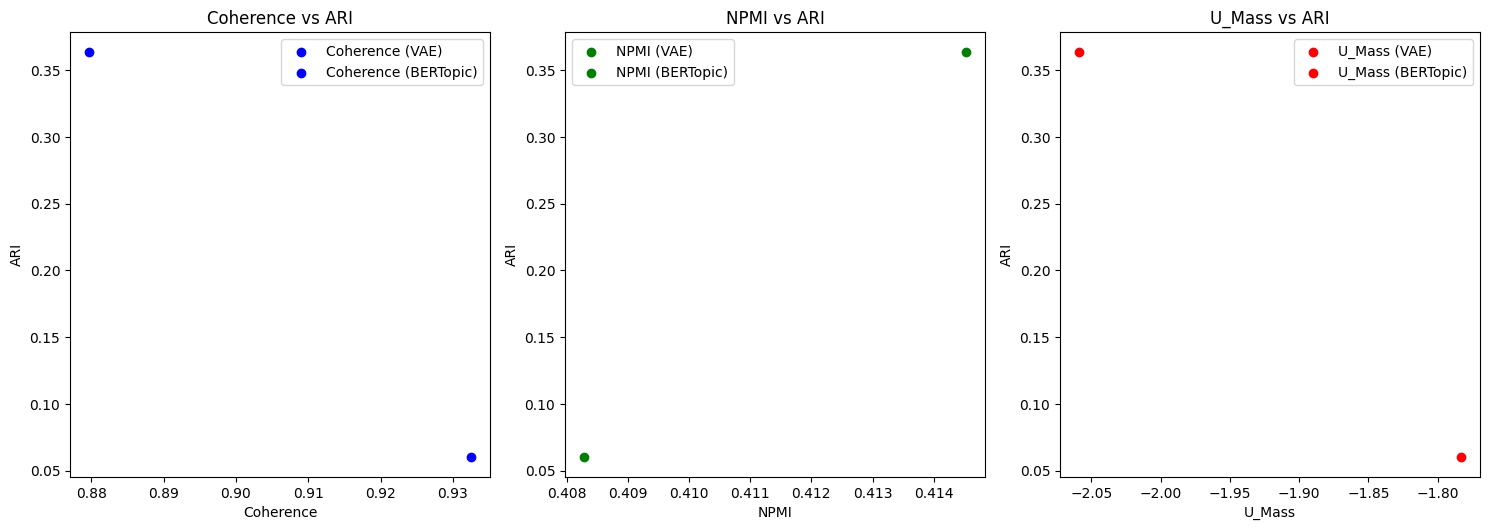

In [17]:
def main(file_path):
    try:
        # 데이터 로드
        logging.info("Loading data...")
        data = pd.read_csv(file_path)
        
        # 레이블 인코딩
        label_encoder = LabelEncoder()
        data['label_encoded'] = label_encoder.fit_transform(data['label'])

        # TF-IDF 변환
        vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
        doc_term_matrix = vectorizer.fit_transform(data['text'])
        input_dim = doc_term_matrix.shape[1]

        # VAE 모델 설정
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        vae_model = VAE(input_dim=input_dim).to(device)
        optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3)
        scaler = MinMaxScaler()
        normalized_matrix = scaler.fit_transform(doc_term_matrix.toarray())
        data_loader = DataLoader(torch.tensor(normalized_matrix).float(), batch_size=64, shuffle=True)

        # VAE 학습
        logging.info("Training VAE model...")
        num_epochs = 5
        for epoch in range(num_epochs):
            train_vae(vae_model, optimizer, data_loader, device, epoch)

        # VAE 토픽 추출
        vae_topics = extract_vae_topics(vae_model, normalized_matrix, device)
        data['vae_topic'] = vae_topics
        ari_vae = adjusted_rand_score(data['label_encoded'], data['vae_topic'])
        logging.info(f"ARI for VAE: {ari_vae:.4f}")

        # BERTopic 모델링     
        logging.info("Performing BERTopic modeling...")
        bertopic_model, bertopic_topics, num_topics, bertopic_document_topics = perform_bertopic_modeling(data['text'])
        data['bertopic_topic'] = bertopic_document_topics
        ari_bertopic = adjusted_rand_score(data['label_encoded'], data['bertopic_topic'])
        logging.info(f"ARI for BERTopic: {ari_bertopic:.4f}")

        # 일관성 지표 계산
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        bert_model = BertModel.from_pretrained('bert-base-uncased')
        
        metrics_list = []
        vae_topics = [vectorizer.get_feature_names_out()[topic.argsort()[-10:]] for topic in vae_model.fc4.weight.data]
        process_metrics('VAE', vae_topics, data, metrics_list, tokenizer, bert_model)
        process_metrics('BERTopic', bertopic_topics, data, metrics_list, tokenizer, bert_model)


        # 상관관계 분석
        ari_list = [ari_vae, ari_bertopic]
        correlation_coherence, correlation_npmi, correlation_umass = calculate_correlation(metrics_list, ari_list)

        # 결과 시각화
        plot_metrics(metrics_list, ari_list)

        # 결과 저장
        results = pd.DataFrame(metrics_list)
        results['ARI'] = ari_list
        results.to_csv('topic_modeling_results.csv', index=False)
        logging.info("Results saved to 'topic_modeling_results.csv'")

    except Exception as e:
        logging.error(f"An error occurred: {str(e)}")
        raise

# 파일 경로 설정
file_path = 'data/pre_data.csv'

# 파일 존재 확인 및 main 함수 실행
if not os.path.exists(file_path):
    print(f"Error: File not found: {file_path}")
else:
    main(file_path)